In [1]:
import dicom
import matplotlib.pyplot as plt

%matplotlib inline

from pathlib import Path
import tensorflow as tf
import numpy as np
from tqdm import tqdm_notebook
import scipy.misc
from skimage import io
import scipy.stats
import seaborn as sns
import skimage.color
from skimage.filters import threshold_otsu
import keras

from matplotlib import animation
from IPython.display import HTML
from PIL import Image
import pandas as pd

Using TensorFlow backend.


In [2]:
dicom_files = [x for x in Path('./torso/rfmri/MR').iterdir() if x.is_file() and not 'ds_store' in str(x).lower()]
dicom_files.sort(key=str)

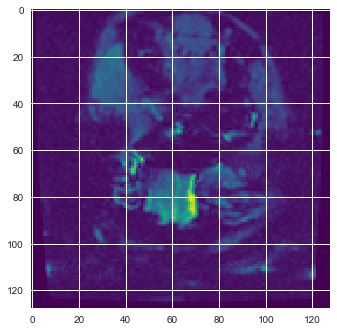

In [127]:
# here's our sample pig in false color image form (veridis cmap)
pig0 = dicom.read_file(str(dicom_files[6]), force=True)
im = pig0.pixel_array
plt.imshow(im, cmap='viridis')

In [4]:
pig0.dir()

['AccessionNumber',
 'AcquisitionDate',
 'AcquisitionMatrix',
 'AcquisitionNumber',
 'AcquisitionTime',
 'AdditionalPatientHistory',
 'AngioFlag',
 'BitsAllocated',
 'BitsStored',
 'CardiacNumberOfImages',
 'Columns',
 'ContentDate',
 'ContentTime',
 'DeviceSerialNumber',
 'EchoNumbers',
 'EchoTime',
 'EchoTrainLength',
 'FlipAngle',
 'FrameOfReferenceUID',
 'HeartRate',
 'HighBit',
 'ImageOrientationPatient',
 'ImagePositionPatient',
 'ImageType',
 'ImagedNucleus',
 'ImagesInAcquisition',
 'ImagingFrequency',
 'InPlanePhaseEncodingDirection',
 'InStackPositionNumber',
 'InstanceNumber',
 'InstitutionName',
 'InversionTime',
 'LargestImagePixelValue',
 'Laterality',
 'MRAcquisitionType',
 'MagneticFieldStrength',
 'Manufacturer',
 'ManufacturerModelName',
 'Modality',
 'NameOfPhysiciansReadingStudy',
 'NumberOfAverages',
 'NumberOfTemporalPositions',
 'OperatorsName',
 'PatientAge',
 'PatientBirthDate',
 'PatientID',
 'PatientName',
 'PatientPosition',
 'PatientSex',
 'PatientWeight',


In [5]:
len(dicom_files) / 47

120.0

In [6]:
# let's try loading the entire thing to ram
# the big tensor will have dimension [time, depth, height, width]


im = pig0.pixel_array
all_data = np.zeros((120, 47, im.shape[0], im.shape[1]))

for f in tqdm_notebook(dicom_files):
    pigfile = dicom.read_file(str(f), force=True)
    
    try:
    
        time = (pigfile.InstanceNumber - 1) // 47
        depth = pigfile.InStackPositionNumber - 1


        if np.count_nonzero(all_data[time, depth]) > 0:
            print('repeated stack position @ time %d , depth %d' % (time, depth))

        all_data[time, depth, ...] = pigfile.pixel_array
    except:
        print(f)
    
    

In [7]:
assert all_data.shape == (120, 47, 128, 128) # basic sanity check

In [8]:
# extract all slices at t=0 in png to annotate with imagej
slicedir = Path('./seg_slices')
slicedir.mkdir(exist_ok=True)

for i, brain_slice in enumerate(tqdm_notebook(all_data[0])):
    filename = './seg_slices/slice_{}.png'.format(i)
    scipy.misc.toimage(brain_slice).save(filename)
    
    
# then use this thing to segment in 3d http://imagej.net/Trainable_Weka_Segmentation

In [9]:
import scipy.stats

scipy.stats.describe(all_data[0].flat)

DescribeResult(nobs=770048, minmax=(0.0, 5599.0), mean=377.42074000581783, variance=150212.03951245255, skewness=2.1149271851111107, kurtosis=5.985433753819269)

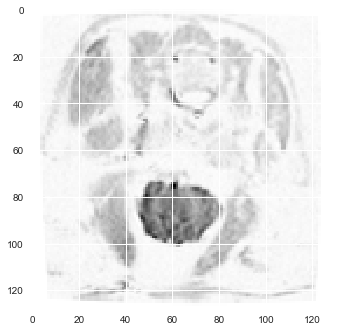

In [10]:
im = plt.imshow(all_data[0, 22, :, :], animated=True)

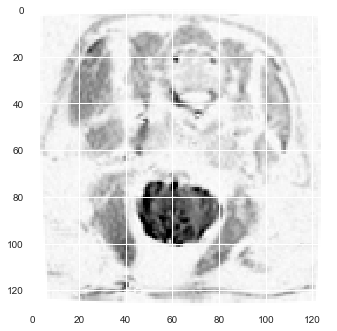

In [20]:
fig, ax = plt.subplots()
im = plt.imshow(all_data[0, 0, :, :], animated=True, interpolation='none')

def animate(i):
    im.set_array(all_data[i % 120, 22])  # going in time at middle of head from top
#     im.set_array(all_data[0, i % 47]) # going in from top of head
#     im.set_array(all_data[0, :, :, i % 128]) # going in from cheek
#     im.set_array(all_data[i%120, :, :, 70]) # going in time at slice in middle of head from cheek
#     im.set_array(all_data[0, :, i % 128, :]) # going in from snout
    
    return im,

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, interval=100, blit=True)

HTML(anim.to_html5_video())

(47, 128, 128)
Intensity at point (80, 60, 20) (y,x,z) is 65280
Intensity at point (0, 0, 20) (y,x,z) is 20224
Showing binary mask for slice 20:


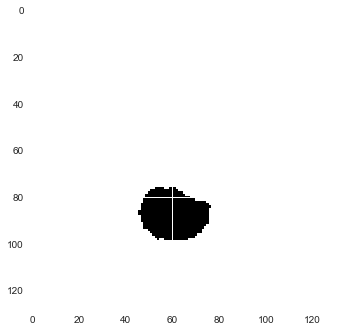

In [80]:
# gotta transform the segmentation mask into a binary image
color_mask = io.imread('./t0_segment_v1.tif')

print(color_mask.shape[:-1])
print('Intensity at point (80, 60, 20) (y,x,z) is ' + str(color_mask[22,80,60,0]))
print('Intensity at point (0, 0, 20) (y,x,z) is ' + str(color_mask[22,0,0,0]))

gray_slice = skimage.color.rgb2gray(color_mask[20])

print('Showing binary mask for slice 20:')
thresh = threshold_otsu(skimage.color.rgb2gray(color_mask[20])[80])
thresholded_slice = gray_slice <= thresh

plt.imshow(thresholded_slice)

In [96]:
binary_mask = np.zeros(color_mask.shape[:-1])

# Take each slice and combine rgb into gray scale (0 - 1) values
for i, z_slice in enumerate(color_mask):
    gray_slice = skimage.color.rgb2gray(z_slice)
    
    if np.max(gray_slice) == np.min(gray_slice):
        # only one color in this slice, it must be a brainless slice
        print('no brain in slice %d' % i)
        binary_slice = np.zeros(gray_slice.shape[:2]) >= 1
    else:
        thresh = threshold_otsu(gray_slice)
        binary_slice = gray_slice <= thresh

    binary_mask[i] = binary_slice

io.imsave('./t0_bin_segment_v1.tif', binary_mask)

no brain in slice 0
no brain in slice 1
no brain in slice 2
no brain in slice 3
no brain in slice 4
no brain in slice 5
no brain in slice 45


In [122]:
# use annotation to select pixels from volume
binary_mask = io.imread('./t0_bin_segment_v1.tif')
indices = np.nonzero(binary_mask)

(47, 128, 128)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
1.0


(13550,)


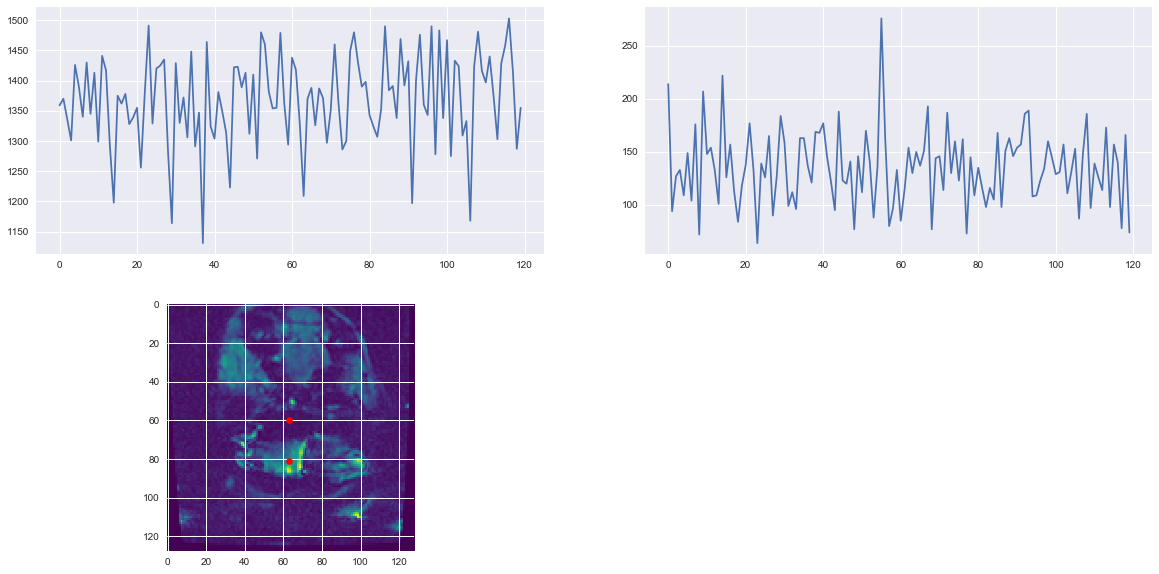

In [141]:
df_index = pd.MultiIndex.from_tuples(list(zip(*indices)), names=['depth', 'col', 'row'])
series_df = pd.Series(index=df_index, dtype=object)

# Sanity check-- compare these all plots
# The one on the left at slice 6, y = 81, x = 63 is in the "brain region"
# The one on the right at slice 6, y = 60, x = 63 is not in the "brain region"
plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.plot(all_data[:, 6, 81, 63])
plt.subplot(222)
plt.plot(all_data[:, 6, 60, 63])
plt.subplot(223)
plt.imshow(all_data[0, 6, :, :], cmap='viridis')
plt.scatter(x=[63, 63], y=[81, 60], c='r', s=40)

for i, triple in tqdm_notebook(enumerate(zip(*indices)), total=len(indices[0])):
    d, c, r = triple
    trace = all_data[:, d, c, r] #get time series for any depth, column, row set
    series_df.loc[triple] = trace
    
print(series_df.shape)
    


In [238]:
mylist = series_df.tolist()
maximum = np.array(mylist).flatten().max()
minimum = np.array(mylist).flatten().min()
list_range = maximum-minimum
list_mean = np.array(mylist).flatten().mean()


normalized_list = (mylist - list_mean)/list_range
shuffled_normalized_list = np.random.permutation(normalized_list)

validation_set = shuffled_normalized_list[:1000] #hold back 1000 for validation
training_set = shuffled_normalized_list[1000:]   #train on 12550 samples
print(validation_set.shape)
print(training_set.shape)


(1000, 120)
(12550, 120)


In [304]:

from keras.layers.convolutional import Conv1D, UpSampling1D
from keras.layers.pooling import MaxPooling1D
from keras.layers.core import Dense, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers import Input
from keras.models import Model

model = keras.models.Sequential()

input_array = Input(shape=(120,1))

first_conv_layer = Conv1D(256, 10, activation='relu', padding='causal')(input_array)
first_pool_layer = MaxPooling1D()(first_conv_layer)
second_conv_layer = Conv1D(128, 5, activation='relu', padding='causal')(first_pool_layer)
second_pool_layer = MaxPooling1D()(second_conv_layer)
third_conv_layer = Conv1D(64, 5, activation='relu', padding='causal')(second_pool_layer)
third_pool_layer = MaxPooling1D()(third_conv_layer)

encoded_image = Dense(120)(third_pool_layer)

first_deconv_layer = Conv1D(64, 5, activation='relu', padding='causal')(encoded_image)
first_upsample_layer = UpSampling1D()(first_deconv_layer)
second_deconv_layer = Conv1D(128, 5, activation='relu', padding='causal')(first_upsample_layer)
second_upsample_layer = UpSampling1D()(second_deconv_layer)
third_deconv_layer = Conv1D(256, 10, activation='relu', padding='causal')(second_upsample_layer)
third_upsample_layer = UpSampling1D()(third_deconv_layer)

fully_connected_layer = Conv1D(1, 1, activation='linear', padding='causal')(third_upsample_layer)

decoded_image = fully_connected_layer
autoencoder = Model(input_array, decoded_image)

opt = optimizers.RMSprop(lr=0.01)
autoencoder.compile(optimizer=opt, loss='mse')

v_data = np.reshape(validation_set, (len(validation_set), 120, 1))
t_data = np.reshape(training_set, (len(training_set), 120, 1))

autoencoder.fit(t_data, t_data, 
      epochs=10, 
      batch_size=32, 
      shuffle=True, 
      validation_data=(v_data, v_data))


Train on 12550 samples, validate on 1000 samples
Epoch 1/10
12550/12550 [==============================] - 289s - loss: 6410.8101 - val_loss: 0.0020
Epoch 2/10
12550/12550 [==============================] - 359s - loss: 2.5722 - val_loss: 0.0072
Epoch 3/10
12550/12550 [==============================] - 355s - loss: 0.0190 - val_loss: 0.0071
Epoch 4/10
12550/12550 [==============================] - 337s - loss: 0.0076 - val_loss: 0.0071
Epoch 5/10
12550/12550 [==============================] - 391s - loss: 0.0076 - val_loss: 0.0071
Epoch 6/10
12550/12550 [==============================] - 376s - loss: 0.0076 - val_loss: 0.0072
Epoch 7/10
12550/12550 [==============================] - 355s - loss: 0.0076 - val_loss: 0.0073
Epoch 8/10
12550/12550 [==============================] - 346s - loss: 0.0076 - val_loss: 0.0074
Epoch 9/10
12550/12550 [==============================] - 345s - loss: 0.0076 - val_loss: 0.0073
Epoch 10/10
12550/12550 [==============================] - 300s - loss: 0.0

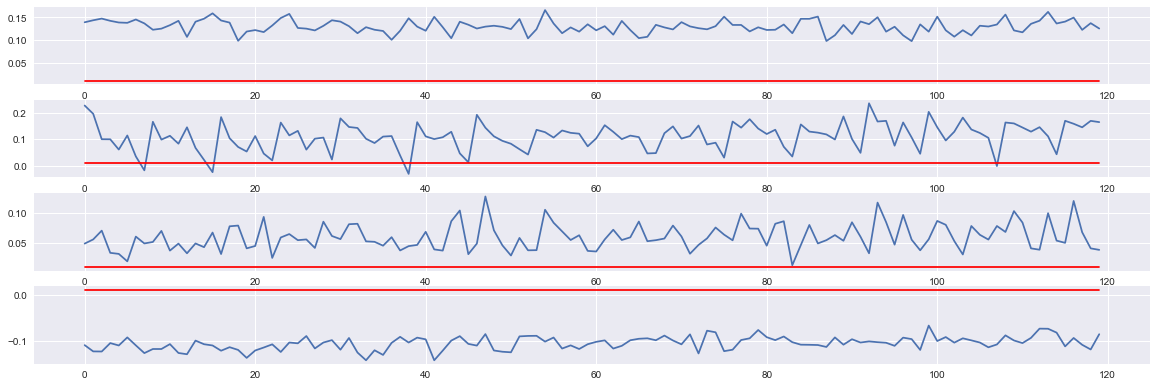

In [308]:
sample_1 = np.reshape(t_data[1,:,:],(1,120,1))
output_1 = autoencoder.predict(sample_1)

sample_2 = np.reshape(t_data[2,:,:],(1,120,1))
output_2 = autoencoder.predict(sample_2)

sample_3 = np.reshape(t_data[3,:,:],(1,120,1))
output_3 = autoencoder.predict(sample_3)

sample_4 = np.reshape(t_data[4,:,:],(1,120,1))
output_4 = autoencoder.predict(sample_4)

plt.figure(figsize=(20, 10))
plt.subplot(611)
plt.plot(np.squeeze(sample_1))
plt.plot(np.squeeze(output_1), c='r')
plt.subplot(612)
plt.plot(np.squeeze(sample_2))
plt.plot(np.squeeze(output_2), c='r')
plt.subplot(613)
plt.plot(np.squeeze(sample_3))
plt.plot(np.squeeze(output_3), c='r')
plt.subplot(614)
plt.plot(np.squeeze(sample_4))
plt.plot(np.squeeze(output_4), c='r')
